# BT4222 Group 12 Model Building

In [1]:
!pip install demoji

     ---------------------------------------- 42.9/42.9 KB 2.2 MB/s eta 0:00:00


In [3]:
!pip install hyperopt

     ---------------------------------------- 1.6/1.6 MB 16.7 MB/s eta 0:00:00
     ---------------------------------------- 199.7/199.7 KB ? eta 0:00:00


## Import Libraries

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
from datetime import datetime, timedelta
import time
import demoji
import os
import pickle
import warnings

# helper libraries
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import metrics

# models
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import tree
from xgboost import XGBRegressor
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from hyperopt.pyll import scope

warnings.filterwarnings("ignore")

 Data is manually cleaned after EDA

In [6]:
# from google.colab import drive
# drive.mount('/content/gdrive')

bitcoin_data_final = pd.read_excel('ProcessedData_Cleaned_With_Model_updated_v2.xlsx')

## Feature Engineering + Simple EDA

<AxesSubplot:xlabel='target'>

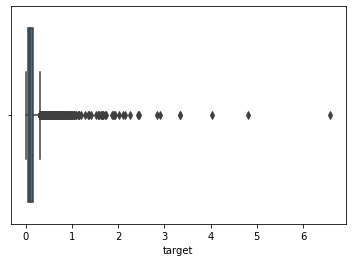

In [7]:
### remove numerical tokens
bitcoin_data_final['title_lemmatized_nonum'] = bitcoin_data_final['title_lemmatized'].apply(str).apply(lambda x: re.sub(r'\d+', '', x))

### convert emojis to list of emojis (str)
def convert_emoji_to_text(text):
    emoji_list = list(set(demoji.findall_list(text)))
    return ['emoji ' + i for i in emoji_list]
bitcoin_data_final['emojis'] = bitcoin_data_final['emojis'].apply(str).apply(lambda x: convert_emoji_to_text(x))

### target variable
bitcoin_data_final['target'] = bitcoin_data_final['Views']/(bitcoin_data_final['Subscribers'])
sns.boxplot(bitcoin_data_final['target'])

In [8]:
def remove_outlier_IQR(df):
    Q1=df['target'].quantile(0.25)
    Q3=df['target'].quantile(0.75)
    IQR=Q3-Q1
    df_final=df[~((df['target']<(Q1-1.5*IQR)) | (df['target']>(Q3+1.5*IQR)))]
    return df_final.reset_index(drop=True)

bitcoin_data_final = remove_outlier_IQR(bitcoin_data_final)

bitcoin_data_final.shape

(13675, 33)

In [13]:
### determine categorical and numerical features
numerical_ix = ['HashtagCount', 'ExclamationCount','QuestionCount', 'NumWords']
categorical_ix = ['HasHashtag','Total Seconds bins','HasCaps','HasPrediction','emojis']
text_chosen = 'title_lemmatized_nonum'

In [14]:
### setup explanatory and target variables
selected_cols =  numerical_ix + categorical_ix
selected_cols.append(text_chosen)

X, y = bitcoin_data_final[selected_cols],  bitcoin_data_final['target']

In [15]:
X.shape

(13675, 10)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=2022,
                                                    shuffle = True)

X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
X_test, y_test = X_test.reset_index(drop=True), y_test.reset_index(drop=True)

## Objective Function

In [20]:
### helper functions

def evaluate(y_true, y_pred, vect, model, text_only=True, obj_func=False):
    """
    Main objective of this function is to calculate evaluation metrics such as RMSE and MSE based on given predicted and actual target values

    Parameters:
    ---------
    (1) y_true: actual target variable
    (2) y_pred: model predicted target variable
    (3) vect: vector used for text column (TfidfVectorizer / CountVectorizer)
    (4) model: regression model used to fit data
    (5) text_only (optional): boolean flag to indicate if only text data was used or not

    Returns:
    -------
    if obj_func = True:
        (1) dictionary of metric results
    else:
        (1) RMSE score
    
    """
    
    def mse(y_predicted, y_true):
        return np.mean(np.square(np.subtract(np.array(y_predicted), np.array(y_true))))
    
    mse = mse(y_pred, y_true)
    rmse = np.sqrt(mse)

    if obj_func:
        return rmse

    else:
        return {"MSE": mse, 
                "RMSE": rmse,
                "Vect Used": vect,
                "Model Used": model,
                "TextOnly": text_only}

def feature_encoding(X_train, X_test, vect, text_only=True):
    """
    Main objective of this function is to convert original dataset into features
        - text data to document term matrix
        - one hot encoding on emojis
        - one hot encoding on categorical variables
        - concatenate all features into a single df

    Parameters:
    ---------
    (1) X_train: training data set (done after kfold except testing on out-of-sample data)
    (2) X_test: test data set (done after kfold except testing on out-of-sample data)
    (3) vect: vector used for text column (TfidfVectorizer / CountVectorizer)
    (4) text_only (optional): boolean flag to indicate if only text data was used or not

    Returns:
    -------
    (1) X_train_combined:
    (2) X_test_combined:
    
    """

    X_train_mat = vect.fit_transform(X_train[text_chosen])
    X_test_mat = vect.transform(X_test[text_chosen])
    features = vect.get_feature_names_out()

    X_train_dtm = pd.DataFrame(data=X_train_mat.toarray(), columns = features)
    X_test_dtm = pd.DataFrame(data=X_test_mat.toarray(), columns = features)
    
    if text_only:
        
        X_train_combined, X_test_combined = X_train_dtm, X_test_dtm

    else:
      
        # numerical features
        X_train_num_transformed = X_train[numerical_ix]
        X_test_num_transformed = X_test[numerical_ix]

        # emojis
        one_hot_emoji_train = pd.get_dummies(X_train['emojis'].apply(pd.Series).stack()).sum(level=0)
        one_hot_emoji_test = pd.get_dummies(X_test['emojis'].apply(pd.Series).stack()).sum(level=0)
        one_hot_emoji_test_dropped = one_hot_emoji_test.drop(columns=[x for x in one_hot_emoji_test.columns if x not in one_hot_emoji_train.columns])
        for col in one_hot_emoji_train.columns:
            if col not in one_hot_emoji_test_dropped.columns:
                one_hot_emoji_test_dropped[col] = 0

        # video length
        one_hot_seconds_train = pd.get_dummies(X_train['Total Seconds bins'].apply(pd.Series).stack()).sum(level=0) # one-hot encoding
        one_hot_seconds_train.columns = [x.replace('(','').replace(']','').replace(',', ' to') + ' seconds' for x in one_hot_seconds_train.columns]
        one_hot_seconds_test = pd.get_dummies(X_test['Total Seconds bins'].apply(pd.Series).stack()).sum(level=0) # one-hot encoding
        one_hot_seconds_test.columns = [x.replace('(','').replace(']','').replace(',', ' to') + ' seconds' for x in one_hot_seconds_test.columns]
        one_hot_seconds_test = one_hot_seconds_test.reindex(columns = one_hot_seconds_train.columns, fill_value=0)

        # combine all features
        X_train_combined = X_train_dtm.join(one_hot_emoji_train).join(one_hot_seconds_train).join(X_train[['HasHashtag','HasCaps','HasPrediction']]).join(X_train_num_transformed).fillna(0)
        X_test_combined = X_test_dtm.join(one_hot_emoji_test_dropped).join(one_hot_seconds_test).join(X_test[['HasHashtag','HasCaps','HasPrediction']]).join(X_test_num_transformed).fillna(0)
    
    return X_train_combined, X_test_combined

def create_folds(df, n_s, n_grp, plot=False):
    df['Fold'] = -1

    kf = StratifiedKFold(n_splits=n_s, shuffle=True)
    df['grp'] = pd.cut(df.target, n_grp, labels=False)
    target = df.grp

    for fold_no, (t, v) in enumerate(kf.split(target, target)):
        df.loc[v, 'Fold'] = fold_no
    
    ### plot k-fold distribution to ensure equal distribution
    if plot:
        fig, axs = plt.subplots(1, n_s, sharex=True, sharey=True, figsize=(10,4))
        for i, ax in enumerate(axs):
            ax.hist(df[df.Fold == i]['target'], bins=100, density=True, label=f'Fold-{i}')
            if i == 0:
                ax.set_ylabel('Frequency')
            if i == 2:
                ax.set_xlabel("Target")
            ax.legend(frameon=False, handlelength=0)
        plt.tight_layout()
        plt.show()

    return df.drop(columns=['grp'])

In [34]:
### main training function (stratified kfold)

def resample_train_and_evaluate_model(x, y, vect, model, text_only=True, obj_function=False, plot=False):
    """

    

    """
    y_true, y_preds = [], []
    num_folds = 5
    num_bins = 5 # pseudo-categorical
    
    df = pd.concat([x,y], axis=1)
    folded_df = create_folds(df, num_folds, num_bins, plot)
  
    for i in tqdm(range(num_folds)):
        curr_train, curr_test = folded_df[df.Fold != i], folded_df[df.Fold == i]
        x_train, x_test = curr_train.drop(columns=['target','Fold']), curr_test.drop(columns=['target','Fold'])
        y_train, y_test = curr_train['target'], curr_test['target']

        x_train_df, x_test_df = feature_encoding(x_train, x_test, vect, text_only)

        model.fit(x_train_df, y_train)

        y_pred = model.predict(x_test_df)
        y_preds.extend(y_pred)
        y_true.extend(y_test)

    return evaluate(y_true, y_preds, vect, model, text_only, obj_function)

## Pick Best Text Vectorizer

In [26]:
### initialise df to store model results
res_test = pd.DataFrame()

def countvectorizer_evaluate(res_test, x, y, model):
    count_vect_args = {'default':{},
                      'without setting to lowercase and remove stopwords':{'lowercase':False, 'stop_words':'english'},
                      'without setting to lowercase':{'lowercase':False},
                      }

    pbar = tqdm(total=len(count_vect_args))
    for k,v in count_vect_args.items():
        vect = CountVectorizer(**count_vect_args[k])
        results = resample_train_and_evaluate_model(x, y, vect, model)
        res_test=res_test.append(results,ignore_index=True)
        pbar.update(1)

    return res_test

def tfidfvectorizer_evaluate(res_test, x, y, model):
    tfidf_vect_args = {'default':{},
                      'without setting to lowercase and remove stopwords':{'lowercase':False, 'stop_words':'english'},
                      'without setting to lowercase':{'lowercase':False},
                      }

    pbar = tqdm(total=len(tfidf_vect_args))
    for k,v in tfidf_vect_args.items():
        vect = TfidfVectorizer(**tfidf_vect_args[k])
        results = resample_train_and_evaluate_model(x, y, vect, model)
        res_test=res_test.append(results,ignore_index=True)
        pbar.update(1)

    return res_test

In [28]:
base_testing_model = tree.DecisionTreeRegressor(max_depth = 50, min_samples_split = 100, random_state=2022)
res_test = countvectorizer_evaluate(res_test, X_train, y_train, base_testing_model)


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [03:52<00:00, 77.44s/it]


In [29]:
base_testing_model = tree.DecisionTreeRegressor(max_depth = 50, min_samples_split = 100, random_state=2022)
res_test = tfidfvectorizer_evaluate(res_test, X_train, y_train, base_testing_model)


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [04:10<00:00, 83.46s/it]


In [31]:
res_test

,MSE,RMSE,Vect Used,Model Used,TextOnly
0,0.003965,0.062972,CountVectorizer(),"DecisionTreeRegressor(max_depth=50, min_sample...",1.0
1,0.003755,0.061274,"CountVectorizer(lowercase=False, stop_words='e...","DecisionTreeRegressor(max_depth=50, min_sample...",1.0
2,0.003708,0.060890,CountVectorizer(lowercase=False),"DecisionTreeRegressor(max_depth=50, min_sample...",1.0
3,0.004376,0.066150,TfidfVectorizer(),"DecisionTreeRegressor(max_depth=50, min_sample...",1.0
4,0.003921,0.062616,"TfidfVectorizer(lowercase=False, stop_words='e...","DecisionTreeRegressor(max_depth=50, min_sample...",1.0
5,0.003869,0.062202,TfidfVectorizer(lowercase=False),"DecisionTreeRegressor(max_depth=50, min_sample...",1.0


## Build Model

In [32]:
vect = CountVectorizer(lowercase=False, stop_words='english')

### Base Decision Tree Model

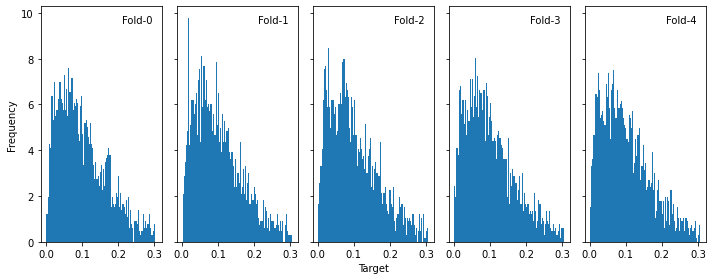


  0%|                                                                                            | 0/3 [48:31<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:58<00:00, 11.68s/it]


In [35]:
base_testing_model = tree.DecisionTreeRegressor(max_depth = 50, min_samples_split = 100, random_state=2022)
results_tree = resample_train_and_evaluate_model(X_train, y_train, vect, base_testing_model, text_only=False, plot=True)
res_test=res_test.append(results_tree,ignore_index=True)

In [37]:
res_test.sort_values(by = "RMSE")

,MSE,RMSE,Vect Used,Model Used,TextOnly
2,0.003708,0.060890,CountVectorizer(lowercase=False),"DecisionTreeRegressor(max_depth=50, min_sample...",1.0
1,0.003755,0.061274,"CountVectorizer(lowercase=False, stop_words='e...","DecisionTreeRegressor(max_depth=50, min_sample...",1.0
6,0.003809,0.061719,"CountVectorizer(lowercase=False, stop_words='e...","DecisionTreeRegressor(max_depth=50, min_sample...",0.0
5,0.003869,0.062202,TfidfVectorizer(lowercase=False),"DecisionTreeRegressor(max_depth=50, min_sample...",1.0
4,0.003921,0.062616,"TfidfVectorizer(lowercase=False, stop_words='e...","DecisionTreeRegressor(max_depth=50, min_sample...",1.0
0,0.003965,0.062972,CountVectorizer(),"DecisionTreeRegressor(max_depth=50, min_sample...",1.0
3,0.004376,0.066150,TfidfVectorizer(),"DecisionTreeRegressor(max_depth=50, min_sample...",1.0


### Decision Tree with Bayes Optimisation Hyperparameter Tuning

In [42]:
### helper functions
if not os.path.exists('/Tuning'): os.mkdir('/Tuning')
    
def save_file(path, data):
    """

    This function saves the model to a .pkl file.

    """

    output = open(path, 'wb')
    pickle.dump(data, output)
    output.close()

def load_file(path):
    """

    This function loads the model from a .pkl file.
    The main reason for doing so is that retraining is not required everytime the code is ran.

    """
    pkl_file = open(path, 'rb')
    data = pickle.load(pkl_file)
    pkl_file.close()
    return data

def hyperopt(param_space, num_eval, vect, model):
    """
    Main hyperparameter tuning function

    Parameters:
    ---------
    (1) param_space: dictionary of parameter values to optimise
    (2) num_eval: number of iterations to optimise over
    (3) vect: vector used for text column
    (4) model: regression model used to fit data

    Returns:
    -------
    (1) trials: dictionary containing optimisation history (parameters, etc)
    (2) best_param_values: dictionary containing the parameters of best model (lowest RMSE)
    
    """

    def objective_function(params):
        regressor = model(**params)
        score = resample_train_and_evaluate_model(X_train, y_train, vect, regressor, text_only=False, obj_function=True) # loss function is RMSE

        return {'loss': score, 'status': STATUS_OK}
    
    trials = Trials()
    best_param = fmin(objective_function, param_space, algo=tpe.suggest, max_evals=num_eval, 
                      trials=trials, rstate= np.random.RandomState(2022))
    loss = [x['result']['loss'] for x in trials.trials] 
    best_param_values = best_param
    print(loss)
    return trials, best_param_values

In [43]:
num_eval = 100 # can increase more for more iterations

### defining parameter space
DT_param_hyperopt = {
    'splitter': hp.choice('splitter', ['best','random']),
    'max_depth': scope.int(hp.quniform('max_depth', 30, 150, 20)),
    'min_samples_split' : scope.int(hp.quniform('min_samples_split', 10, 150, 20)),
    'min_samples_leaf' : scope.int(hp.quniform('min_samples_leaf', 1, 10, 1)),
    'min_weight_fraction_leaf' : hp.uniform('min_weight_fraction_leaf', 0.0, 0.5),
    'random_state':2022
}

In [58]:
load = True # toggle to set to False if want to re-optimise
if load == False:
    DT_hyperopt = hyperopt(DT_param_hyperopt, num_eval, vect, tree.DecisionTreeRegressor)
    save_file('Tuning/DT_hyperopt.pkl', DT_hyperopt)
else:
    try:
        DT_hyperopt = load_file('Tuning/DT_hyperopt.pkl')
    except Exception as e:
        print(e)

In [59]:
trials = DT_hyperopt[0].trials

record = []
losses = []
for trial in trials:
    loss = trial["result"]["loss"]
    values = trial["misc"]['vals']
    losses.append(loss)
    record.append(values)
    
DTTrialsData = pd.DataFrame(record)
DTTrialsData = DTTrialsData.applymap(lambda x: x[0])

DTTrialsData.insert(0, 'loss', losses)
DTTrialsData.sort_values(by='loss', inplace=True)

In [60]:
DTTrialsData.head()

,loss,max_depth,min_samples_leaf,min_samples_split,min_weight_fraction_leaf,splitter
75,0.063877,100.0,4.0,120.0,0.000398,0
49,0.064333,60.0,4.0,100.0,0.001088,0
20,0.064537,80.0,6.0,60.0,0.001068,0
89,0.064616,80.0,4.0,60.0,0.000007,1
37,0.065059,80.0,9.0,80.0,0.001520,0


In [61]:
dt_chosen = DT_hyperopt[1]

dt_model   =   tree.DecisionTreeRegressor(splitter=['best','random'][dt_chosen['splitter']], 
                                          max_depth=int(dt_chosen['max_depth']),
                                          min_samples_split = int(dt_chosen['min_samples_split']),
                                          min_samples_leaf = int(dt_chosen['min_samples_leaf']),
                                          min_weight_fraction_leaf = dt_chosen['min_weight_fraction_leaf'],
                                          random_state=2022)

In [62]:
res_test = res_test.append(resample_train_and_evaluate_model(X, y, vect, dt_model, text_only=False),ignore_index=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:31<00:00, 18.35s/it]


In [63]:
sorted_res = res_test.sort_values(by = 'RMSE')
sorted_res # lower RMSE after tuning

,MSE,RMSE,Vect Used,Model Used,TextOnly
7,0.003654,0.060446,"CountVectorizer(lowercase=False, stop_words='e...","DecisionTreeRegressor(max_depth=100, min_sampl...",0.0
2,0.003708,0.060890,CountVectorizer(lowercase=False),"DecisionTreeRegressor(max_depth=50, min_sample...",1.0
1,0.003755,0.061274,"CountVectorizer(lowercase=False, stop_words='e...","DecisionTreeRegressor(max_depth=50, min_sample...",1.0
6,0.003809,0.061719,"CountVectorizer(lowercase=False, stop_words='e...","DecisionTreeRegressor(max_depth=50, min_sample...",0.0
5,0.003869,0.062202,TfidfVectorizer(lowercase=False),"DecisionTreeRegressor(max_depth=50, min_sample...",1.0
4,0.003921,0.062616,"TfidfVectorizer(lowercase=False, stop_words='e...","DecisionTreeRegressor(max_depth=50, min_sample...",1.0
0,0.003965,0.062972,CountVectorizer(),"DecisionTreeRegressor(max_depth=50, min_sample...",1.0
3,0.004376,0.066150,TfidfVectorizer(),"DecisionTreeRegressor(max_depth=50, min_sample...",1.0


### Testing Model on Out-of-Sample data

In [64]:
def evaluate_model(x_train, y_train, x_test, y_test, vect, model, text_only=False, obj_function=False):
    y_true, y_preds = [], []
    x_train_df, x_test_df = feature_encoding(x_train, x_test, vect, text_only)
    model.fit(x_train_df, y_train)
    y_pred = model.predict(x_test_df)
    y_preds.extend(y_pred)
    y_true.extend(y_test)

    return evaluate(y_true, y_preds, vect, model, text_only, obj_function)

results_test = evaluate_model(X_train, y_train, X_test, y_test, vect, dt_model, text_only=False, obj_function=False)
res_test=res_test.append(results_test,ignore_index=True)

In [65]:
res_test.iloc[len(res_test)-1] ## show latest result

MSE                                                    0.003817
RMSE                                                    0.06178
Vect Used     CountVectorizer(lowercase=False, stop_words='e...
Model Used    DecisionTreeRegressor(max_depth=100, min_sampl...
TextOnly                                                    0.0
Name: 8, dtype: object

In [66]:
test_model = res_test.iloc[len(res_test)-1]['Model Used']

In [67]:
feature_impt = test_model.feature_importances_
x_train_df, x_test_df = feature_encoding(X_train, X_test, vect, False)
feature_names = x_train_df.columns
df = np.vstack((feature_impt, feature_names))

sorted_df = pd.DataFrame(df.T, columns=['Importance','Feature'])
sorted_df.Importance = sorted_df.Importance.astype(float)
sorted_df = sorted_df.sort_values(by = 'Importance', ascending=False)

In [68]:
sorted_df.head(50)

,Importance,Feature
595,0.120167,BITCOIN
8877,0.065192,NumWords
7979,0.057049,XRP
7249,0.050069,Technical
8875,0.042557,ExclamationCount
133,0.033248,ANALYSIS
858,0.028104,Bitcoin
42,0.024360,ADA
1451,0.020554,Chart
1310,0.016353,CRYPTO


In [69]:
sorted_df.to_csv('Feature_Importance.csv', index=False)